# Test task

In [1]:
import pandas as pd
import numpy as np
from small_lib.functions import *
import matplotlib.pyplot as plt
import seaborn as sns

Read the data:

In [22]:
config = {'data_source' : '/home/angelina/Documents/Wnsdor.ai/data/data_science_homework.tsv'}

df = pd.read_csv(config['data_source'], sep='\t', index_col='ids')
print(f'Number og rows: {df.shape[0]}')
df.head(3)

Number og rows: 10000


,gender,last_connection,x1,x2,x3,t1,t2
ids,,,,,,,
1,F,2015-04-27,37.796189,292.189338,85.871732,1102.896732,1814.852022
2,M,2015-04-27,44.523437,294.989423,96.432040,1116.845895,1679.957691
3,F,2015-02-16,90.593723,298.219531,96.915476,1290.882244,1841.987889


#### FIRST STEP

Check data type:

In [3]:
df.dtypes

gender              object
last_connection     object
x1                 float64
x2                 float64
x3                 float64
t1                 float64
t2                 float64
dtype: object

Check NA values:

In [4]:
df.isnull().sum()

gender               0
last_connection    100
x1                   0
x2                   0
x3                   0
t1                   0
t2                   0
dtype: int64

In [5]:
df.last_connection.sort_values().tail(101)

ids
6534    2015-05-10
72             NaN
201            NaN
231            NaN
667            NaN
           ...    
9445           NaN
9542           NaN
9753           NaN
9808           NaN
9817           NaN
Name: last_connection, Length: 101, dtype: object

Only one colum "last connection" has NA values and this values are the last 100 rows. 
I suppose we have to delete this data.

Describe the data, count mean, max,min values per each column:

In [6]:
df.describe()

,x1,x2,x3,t1,t2
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.067047,300.068631,95.055902,1174.859697,1769.174820
std,28.931639,9.889459,9.911644,118.724074,86.214259
min,0.004004,264.463035,62.029833,897.883743,1557.852139
25%,24.719006,293.396488,92.997142,1084.746402,1696.077169
50%,49.876050,300.225596,95.889497,1175.567545,1752.607393
75%,75.389142,306.557144,97.995304,1264.322678,1846.609079
max,99.904798,339.416551,1000.000000,1449.617809,2027.374480


As we see the first feature 'X1' belongs to the interval [0, 100], suppose this value is already normalized. It looks weird that we have the same percentile values as a feature value, the distribution looks perfectly uniform. I mean that 25% percentile it is also ~25 and mean value it is ~50. It looks more like a random uniform distribution, that we can create using np.random.uniform(0, 100, 1000).
The next features 'X2' and 'X3' look more real and distributed not so perfectly. They have almost the same standard deviation, maybe they are correlated with each other or very similar, have to check.
The next features 't1' and 't2' look also really enough, they may also have a correlation with each other.

Let`s count how many data of each gender do we have:

<AxesSubplot:ylabel='gender'>

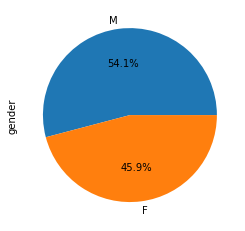

In [7]:
df.gender.value_counts().plot.pie(autopct="%.1f%%")

Let`s check the date column:

In [8]:
#convert to datetime type
df['last_connection'] = df.last_connection.apply(str_to_date)
# df['month'] = df.last_connection.dt.month

date_unique = df.last_connection.dropna().sort_values().drop_duplicates().reset_index(drop = True)
print(f'''Unique number of days: {len(date_unique)}; 
First date: {date_unique[0].date()};
Last date: {date_unique.tolist()[-1].date()}''')

Unique number of days: 100; 
First date: 2015-01-31;
Last date: 2015-05-10


Plot how many data do we have per day:

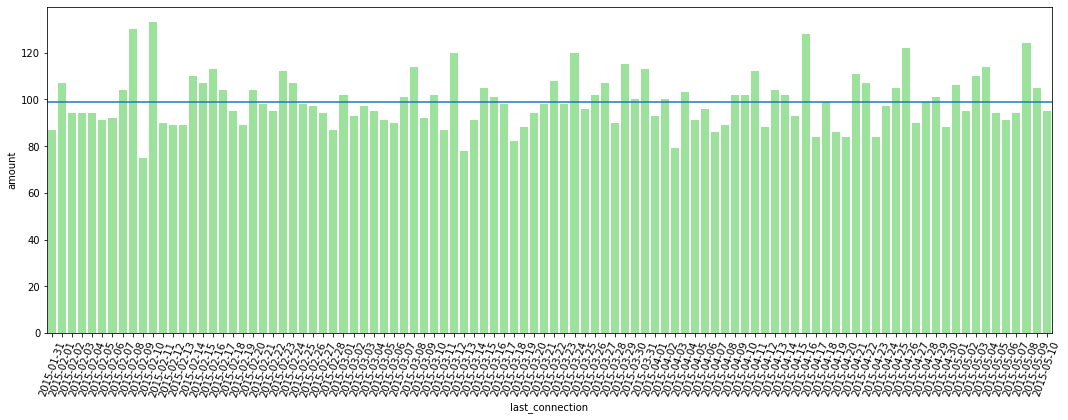

In [9]:
df_ = df.last_connection.value_counts().sort_index().reset_index(name = 'amount').rename(columns =
                                                                            {'index':'last_connection'})
df_['last_connection'] = df_.last_connection.dt.date
plot_barplot(df_, x = 'last_connection', y = 'amount',size = (18,6))

Count number of observation grouper by day of week:

In [10]:
df['dayweek'] = df.last_connection.dt.weekday
df.dayweek.value_counts().sort_index().reset_index(name = 'amount').rename(columns =
                                                                            {'index':'day_of_week'})


,day_of_week,amount
0,0.0,1366
1,1.0,1460
2,2.0,1311
3,3.0,1363
4,4.0,1340
5,5.0,1485
6,6.0,1575


Plot the distribution of features, split by gender:

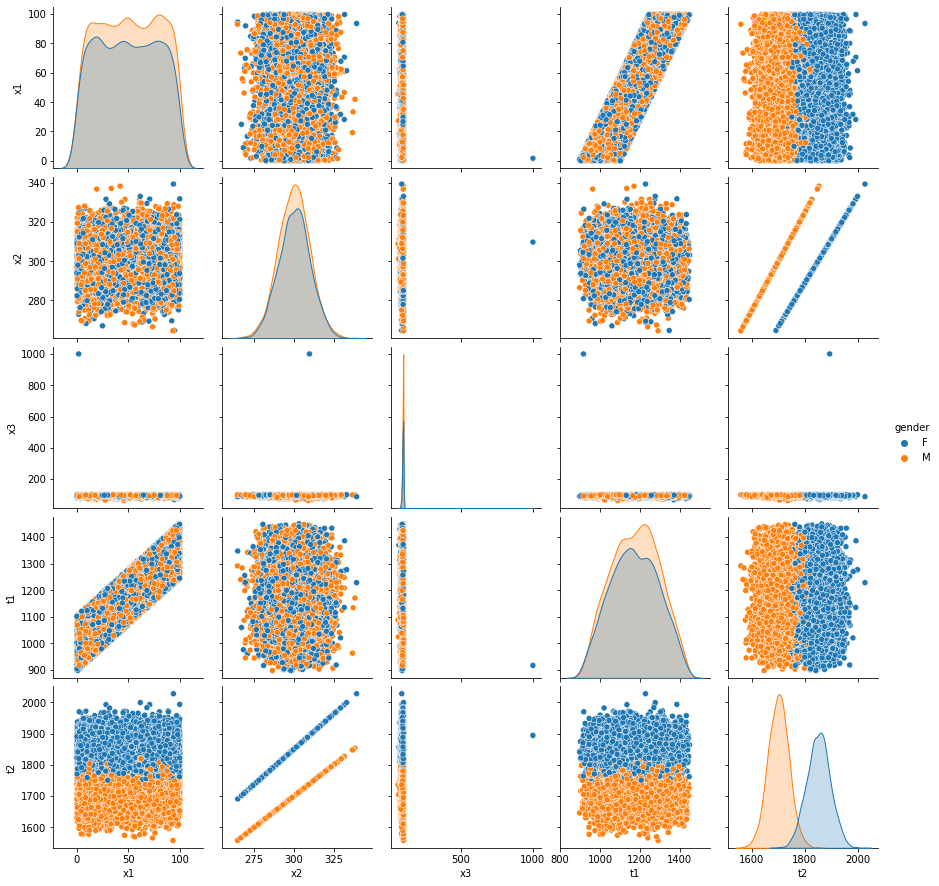

In [23]:
sns.pairplot(df.dropna(), hue = 'gender')

First of all, we see, that x3 has one outlier that has so big deviation from others. I would like to delete this outlier to plot the distribution of the main data.

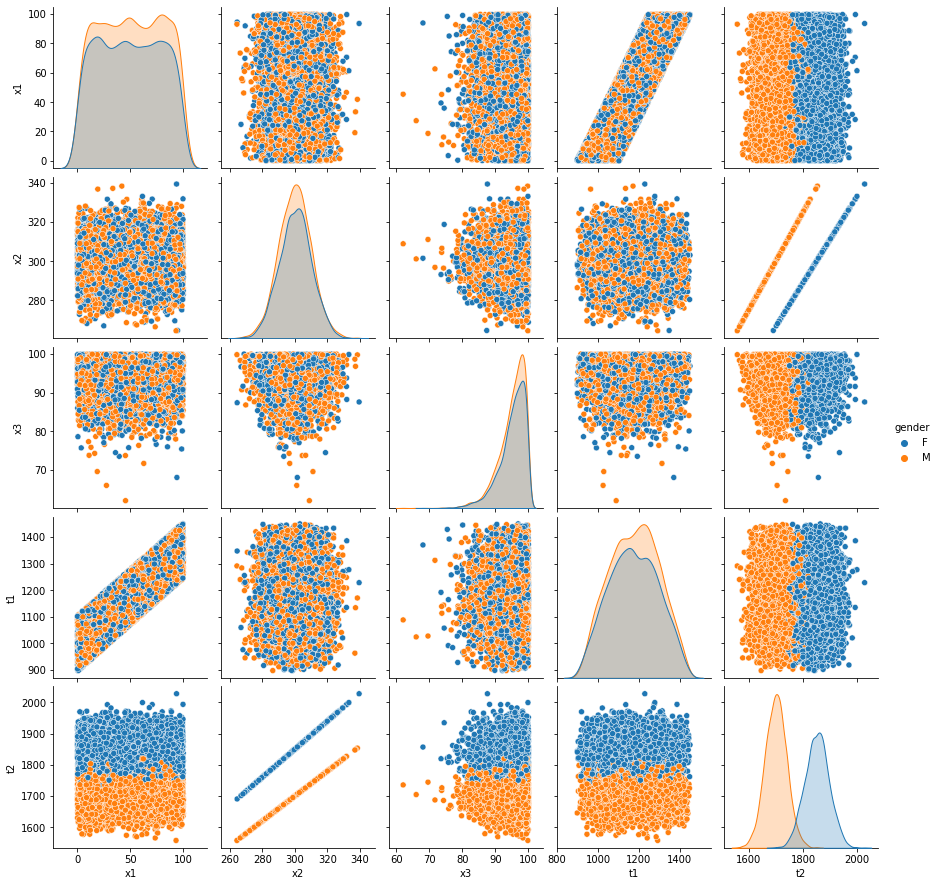

In [24]:
sns.pairplot(df[df.x3 < 1000].dropna(), hue = 'gender')

The distribution of the feature x1 looks enough random and noisy, I suppose it will be hard to model.

As we on the plot, feature x2 has normal symmetric distribution, which is good for modeling, but we can not separate this feature by gender. Feature t2 can separate this data into two line plots, that will be easy to model.

The distribution of feature X3 looks more like exponential distribution.

The distribution of the feature t1 looks symmetric and a little similar to normal distribution. I suppose, there is a correlation between x1 and t1.

The distribution of the feature t2 splits very well by gender to the two distributions.

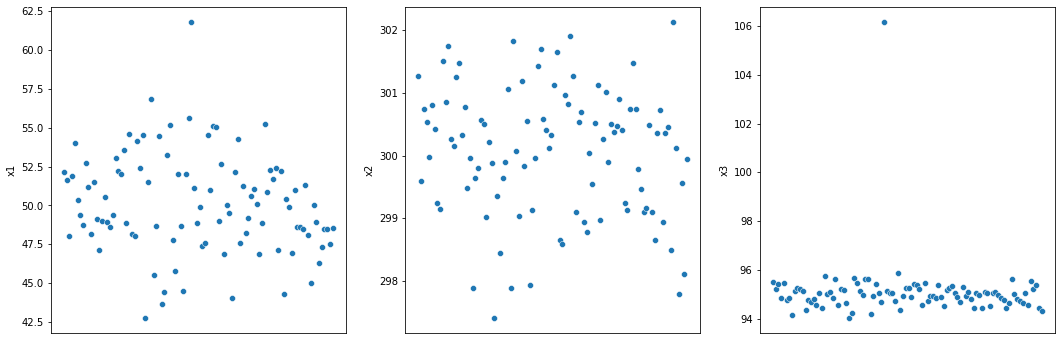

In [45]:
df_ = df.groupby('last_connection').mean().sort_index().reset_index()
fig, axs = plt.subplots(ncols=3,figsize=(18,6))
for i in range(0,3):
    axs[i].set(xticks=[])
    sns.scatterplot(x='last_connection', y=f'x{i+1}', data=df_, ax=axs[i])

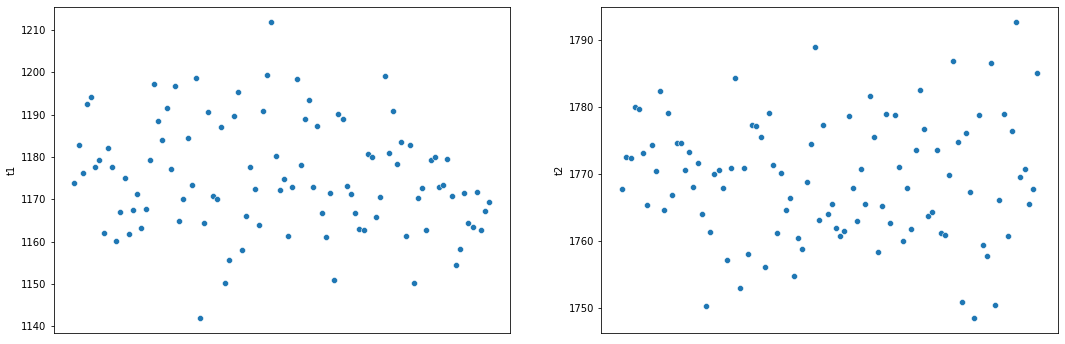

In [50]:
df_ = df.groupby('last_connection').mean().sort_index().reset_index()
fig, axs = plt.subplots(ncols=2,figsize=(18,6))
for i in range(0,2):
    axs[i].set(xticks=[])
    sns.scatterplot(x='last_connection', y=f't{i+1}', data=df_, ax=axs[i])

The distribution of the features looks noisy enough, it is hard to find some trend in a time period. 

 #### SECOND STEP

Count the correlation between the features:

<AxesSubplot:>

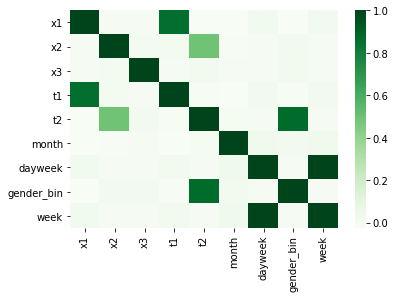

In [13]:
df['gender_bin'] = df.gender.map({'F':1,'M':0})
df['month'] = df.last_connection.dt.month
df['week'] = df.last_connection.dt.weekday

sns.heatmap(df.corr(), cmap="Greens")

In [51]:
top_correlated_features(df)

x1  t1    0.860337
x2  t2    0.497103
x1  t2    0.024020
x3  t2    0.013570
t1  t2    0.013292
dtype: float64

Each feature is correlated with one of the other. The most correlated features are gender and t2.

Considering that t1 and t2 are collected one month after x1, x2, and x3, we have to check a correlation between ( t1, t2) and (x1, x2, x3) but with one month shift. But, we cannot merge this data with a month shift, because we have several observations for each date and we do not know for each x what exactly t value merge for a specific date one month ahead.
We can  count a mean value per day, then split data to x and t data, then subtract one month from t data and merge t and x data by 'last_connection", but we will get low correlation:

In [15]:
result = split_and_merge(df, groupby_col='last_connection')
top_correlated_features(result)

t1  month    0.337086
x2  x3       0.231717
t2  month    0.179405
x1  x3       0.161412
t1  x1       0.146952
dtype: float64

It means that something wrong. I think this question needs more detailed analysis, maybe we should count 30d interval instead of calendar 30-days interval, or something else. Maybe all previous months affect the last month.
Anyway, there is a correlation between the data and some trends. We can try to predict the target values. For this, we have to do a more detailed analysis, generate new features, analyze better the target values, maybe find some outliers, and delete them.